# Assignment 1

#### imports

In [1]:
# for google colab
!pip install tqdm emoji gensim umap-learn rapidfuzz wordcloud nltk torchinfo --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 111.1 MB/s eta 0:00:00


In [2]:
import copy, json, re, os
from typing import List, Callable, Dict
from collections import OrderedDict
import numpy as np
import pandas as pd
from tqdm import tqdm
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
import gensim
import gensim.downloader as gloader
import umap
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
from torchinfo import summary
import torch.optim as optim

In [3]:
def fix_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
fix_seed(0)

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords') # for google colab

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [57]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!cp -r "/content/drive/My Drive/Assignment_NLP/A1/data" /content/

## Task 1

In [6]:
def dataset_from_json(name):
    from collections import Counter
    with open(name, 'r', encoding='utf-8') as f:
        data = json.load(f)
        df = pd.DataFrame.from_dict(data, orient='index')
        df = df[['id_EXIST', 'lang', 'tweet', 'labels_task2']]
        df = df.rename(columns={'labels_task2': 'label'})
        df = df[df['lang'] == 'en']

        def most_frequent_or_drop(arr):
            if not isinstance(arr, list):
                return arr
            c = Counter(arr)
            most_common = c.most_common()
            if len(most_common) == 0:
                return None
            max_count = most_common[0][1]
            candidates = [val for val,
                          count in most_common if count == max_count]
            if len(candidates) > 1:
                return None
            return candidates[0]

        df['label'] = df['label'].apply(most_frequent_or_drop)

        def map_label(label):
            mapping = {
                '-': 0,
                'DIRECT': 1,
                'JUDGEMENTAL': 2,
                'REPORTED': 3
            }
            return mapping.get(label, None)

        df = df.dropna(subset=['label'])
        df['label'] = df['label'].apply(map_label)

    return df

train_df_np = dataset_from_json('data/training.json')
val_df_np = dataset_from_json('data/validation.json')
test_df_np = dataset_from_json('data/test.json')

In [7]:
train_df_np.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,0
200005,200005,en,‘Making yourself a harder target’ basically bo...,0


### Visualize the classes

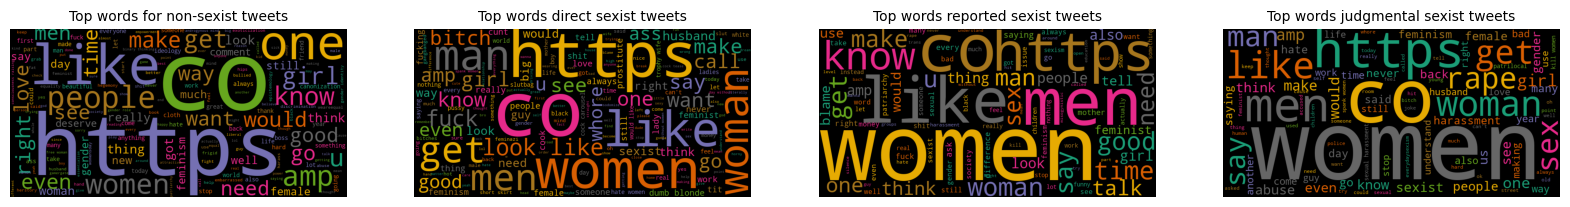

In [ ]:
n_posts = 1000
stop = set(stopwords.words('english'))
q_NS = ' '.join(train_df_np[train_df_np['label'] == 0]['tweet'].str.lower().values[:n_posts])
q_DS = ' '.join(train_df_np[train_df_np['label'] == 1]['tweet'].str.lower().values[:n_posts])
q_RS = ' '.join(train_df_np[train_df_np['label'] == 2]['tweet'].str.lower().values[:n_posts])
q_JS = ' '.join(train_df_np[train_df_np['label'] == 3]['tweet'].str.lower().values[:n_posts])

wordcloud_NS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_NS)
wordcloud_DS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_DS)
wordcloud_RS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_RS)
wordcloud_JS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_JS)

fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(wordcloud_NS)
ax[0].set_title('Top words for non-sexist tweets',fontsize = 10)
ax[0].axis("off")

ax[1].imshow(wordcloud_DS)
ax[1].set_title('Top words direct sexist tweets',fontsize = 10)
ax[1].axis("off")

ax[2].imshow(wordcloud_RS)
ax[2].set_title('Top words reported sexist tweets',fontsize = 10)
ax[2].axis("off")

ax[3].imshow(wordcloud_JS)
ax[3].set_title('Top words judgmental sexist tweets',fontsize = 10)
ax[3].axis("off")

plt.show()

## Task 2

In [8]:
stop_words = set(stopwords.words('english'))  # enhlish stopwords set

def clean_text(text: str) -> str:
    """Remove emojis, URLs, mentions, hashtags, special characters, extra spaces, and stopwords."""
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')  # remove emojis
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)  # remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'["\'`\’\‘\“\”]', ' ', text)  # remove extra quotes

    # remove stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words).strip()

def lemmatize_text(text: str) -> str:
    """Lemmatize text using POS tagging for more accurate results."""
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    words = text.split()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

def text_preprocessing(df, column='tweet', pipeline=None):
    """
    Apply a sequence of preprocessing functions to a dataframe column.

    Parameters:
    - df: pandas DataFrame
    - column: name of the text column
    - pipeline: list of functions to apply sequentially
    """
    df = df.copy()
    if pipeline is None:
        pipeline = [clean_text, lemmatize_text]

    for func in pipeline:
        df[column] = df[column].apply(func)

    return df

In [9]:
pipeline = [clean_text, lemmatize_text]

train_df = text_preprocessing(train_df_np, pipeline=pipeline)
val_df = text_preprocessing(val_df_np, pipeline=pipeline)
test_df = text_preprocessing(test_df_np, pipeline=pipeline)

In [10]:
train_df.head()

,id_EXIST,lang,tweet,label
200001,200001,en,ffs lay blame bastard murder novel idea know,0
200002,200002,en,write uni essay local pub coffee random old ma...,3
200003,200003,en,dont appreciate two ride team member look behi...,3
200004,200004,en,unacceptable use title men interview fact seni...,0
200005,200005,en,make hard target basically boil make sure targ...,0


## Task 3

### Build the vocabulary

In [ ]:
def build_vocabulary(
    df: pd.DataFrame,
    column_name: str = "tweet",
    add_special_tokens: bool = True
):
    """
    Builds a complete vocabulary from a DataFrame column.
    Returns mappings (idx_to_word, word_to_idx), word listing, and frequency DataFrame.

    Parameters:
    - df: DataFrame containing the text column.
    - column_name: Name of the column to process.
    - add_special_tokens: Whether to include <PAD> and <UNK> tokens.
    Returns:
    - idx_to_word (OrderedDict[int, str])
    - word_to_idx (OrderedDict[str, int])
    - word_listing (List[str])
    - vocab_df (pd.DataFrame with 'vocabulary' and 'counts')
    """

    # Builds a list tokens from the tweets
    text_array = df[column_name].values
    list_of_token_lists = [t.split() for t in text_array]
    repeated_vocab = np.concatenate(list_of_token_lists)
    repeated_vocab = repeated_vocab[repeated_vocab != ""]  # removes empty strings

    # Counts the frequency of each word
    token_array, counts_array = np.unique(repeated_vocab, return_counts=True)

    # Sorts by descending frequency
    sorted_indices = np.argsort(-counts_array)
    token_array = token_array[sorted_indices].tolist()
    counts_array = counts_array[sorted_indices]

    # Creates ordered mappings
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0

    if add_special_tokens:
        for tok in ["<PAD>", "<UNK>"]:
            word_to_idx[tok] = curr_idx
            idx_to_word[curr_idx] = tok
            curr_idx += 1

    for token in tqdm(token_array, desc="Building vocabulary"):
        word_to_idx[token] = curr_idx
        idx_to_word[curr_idx] = token
        curr_idx += 1

    # Builds word listing and DataFrame
    word_listing = list(idx_to_word.values())
    vocab_df = pd.DataFrame({"vocabulary": token_array, "counts": counts_array})

    return idx_to_word, word_to_idx, word_listing, vocab_df

In [ ]:
idx_to_word, word_to_idx, word_listing, vocab_df = build_vocabulary(train_df)

print("Size:", len(word_to_idx))
print("Most common words:\n", vocab_df.head(10))
print("Example mapping:", list(word_to_idx.items())[:10])

Building vocabulary: 100%|██████████| 9457/9457 [00:00<00:00, 1275583.13it/s]

Size: 9459
Most common words:
   vocabulary  counts
0      woman     734
1       like     509
2        get     334
3       dont     322
4       make     246
5         go     242
6        say     237
7        men     225
8         im     222
9       know     218
Example mapping: [('<PAD>', 0), ('<UNK>', 1), ('woman', 2), ('like', 3), ('get', 4), ('dont', 5), ('make', 6), ('go', 7), ('say', 8), ('men', 9)]


#### Evaluate the vocabulary

In [ ]:
def evaluate_vocabulary(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    word_listing: List[str],
    df: pd.DataFrame,
    check_default_size: bool = False
):
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    _, _, first_word_listing, _ = build_vocabulary(df)
    _, _, second_word_listing, _ = build_vocabulary(df)
    assert first_word_listing == second_word_listing

In [ ]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, train_df)
print("")
print("Evaluation completed!")

Vocabulary evaluation...


Building vocabulary: 100%|██████████| 9457/9457 [00:00<00:00, 2651793.88it/s]


Evaluation completed!


#### Save the vocabulary

In [ ]:
vocab_path = './data/vocab.json'

print(f"Saving vocabulary to {vocab_path}")
with open(vocab_path, mode='w') as f:
    json.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to ./data/vocab.json
Saving completed!


### OOV words

In [ ]:
embedding_dimension = 50
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
embedding_model = gloader.load(download_path)

In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    Parameters:
    - embedding_model: pre-trained word embedding model (gensim wrapper)
    - word_listing: dataset specific vocabulary (list)
    Returns:
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")
print(oov_terms[:3])

Total OOV terms: 1719 (18.17%)
['thighfcker', 'friendsdont', 'porshas']


### Embedding

In [ ]:
def embedding_from_context(train_df, word, embedding_matrix, context_size=3, embedding_dimension=50):
    """Generate an embedding for an oov word as average of its context in the training data."""
    try:
        for seq in train_df.tweet.values:
            tokens = seq.split()
            if word in tokens:
                pos = tokens.index(word)
                start = max(0, pos - context_size)
                end = min(len(tokens), pos + context_size + 1)
                context_words = [t for t in tokens[start:end] if t != word]
                break
        context_embeddings = []
        for context_word in context_words:
            try:
                context_embeddings.append(embedding_matrix[word_to_idx[context_word]])
            except KeyError:
                # if the context word is also oov, skip it
                continue
        if not len(context_embeddings) > 2:
            raise ValueError("Not enough context embeddings found")

        embedding = np.mean(context_embeddings, axis=0)
    except Exception as e:
        embedding = np.random.uniform(low=-3, high=3, size=embedding_dimension)
    return embedding

def embedding_as_subwords(word, glove, n=3):
    """Generate an embedding for an oov word as average of its subwords."""
    subwords = [word[i:i+n] for i in range(len(word)-n+1)]
    known_subs = [glove[sub] for sub in subwords if sub in glove]
    if known_subs:
        return np.mean(known_subs, axis=0)
    else:
        return np.mean(glove.vectors, axis=0)  # fallback: average vector

def embedding_from_similarity(word, glove, scorer='ratio', top_k=1, min_score=70):
    """Generate an embedding for an oov word as average of its neighbors in the embedding space."""
    vocab_list = glove.index_to_key
    scorer_fn = getattr(fuzz, scorer)
    # Find top_k closest matches by fuzzy similarity
    matches = process.extract(word, vocab_list, limit=top_k, scorer=scorer_fn)
    # Filter out low-similarity matches
    valid_matches = [(w, s) for w, s, _ in matches if s >= min_score]

    if not valid_matches:
        return np.mean(glove.vectors, axis=0)

    # Weighted average of matched embeddings by similarity score
    vectors, weights = [], []
    for w, score in valid_matches:
        vectors.append(glove[w])
        weights.append(score)

    weights = np.array(weights) / np.sum(weights)
    return np.average(vectors, axis=0, weights=weights)

In [ ]:
def build_embedding_matrix(
    embedding_model,
    embedding_dimension: int,
    word_to_idx: Dict[str, int],
    vocab_size: int,
    oov_terms: List[str] = None,
    unk_token: str = "<UNK>",
    oov_strategy: str = "random",
    random_seed: int = 42
) -> torch.Tensor:
    """
    Builds an embedding matrix for a dataset, handling OOV and <UNK> tokens.
    Parameters:
    - embedding_model: pre-trained word embeddings (GloVe)
    - embedding_dimension: dimensionality of embeddings
    - word_to_idx: dictionary mapping words to indices
    - vocab_size: total vocabulary size
    - oov_terms: list of OOV terms from training set
    - unk_token: token used for unseen words in val/test
    - random_seed: for reproducibility of random embeddings
    Returns: embedding matrix (torch.Tensor) of shape [vocab_size, embedding_dimension]
    """
    np.random.seed(random_seed)
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    # Precompute a random vector for <UNK>
    unk_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)

    for word, idx in tqdm(word_to_idx.items(), desc="Building embedding matrix"):
        if word == unk_token:
            embedding_matrix[idx] = unk_vector
        else:
            try:
                embedding_vector = embedding_model[word]
            except KeyError:
                # OOV word
                if oov_strategy == "context":
                    embedding_vector = embedding_from_context(train_df, word, embedding_matrix, context_size=5)
                elif oov_strategy == "mean":
                    mean_embedding = np.mean(embedding_matrix, axis=0)
                    noise = np.random.normal(0, 1, mean_embedding.shape)
                    embedding_vector = mean_embedding + noise
                elif oov_strategy == "subwords" and embedding_model is not None:
                    embedding_vector = embedding_as_subwords(word, embedding_model, n=3)
                elif oov_strategy == "similarity" and embedding_model is not None:
                    embedding_vector = embedding_from_similarity(word, embedding_model, top_k=3)
                else:   # oov_strategy == "random"
                    embedding_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)

            embedding_matrix[idx] = embedding_vector

    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
    return embedding_matrix

In [ ]:
vocab_size = len(word_to_idx)

embedding_matrix = build_embedding_matrix(
    embedding_model=embedding_model,
    embedding_dimension=embedding_dimension,
    word_to_idx=word_to_idx,
    vocab_size=vocab_size,
    oov_terms=oov_terms,
    unk_token="<UNK>",
    oov_strategy="subwords",
)

print()
print(embedding_matrix.shape)  # [vocab_size, embedding_dim]

Building embedding matrix: 100%|██████████| 9459/9459 [00:00<00:00, 24213.03it/s]


torch.Size([9459, 50])


In [ ]:
def co_occurrence_count(df: pd.DataFrame,
                        idx_to_word: Dict[int, str],
                        word_to_idx: Dict[str, int],
                        window_size: int = 4) -> np.ndarray:
    """
    Builds word-word co-occurrence matrix based on word counts.
    Parameters:
    - df: DataFrame containing the text column.
    - idx_to_word: mapping from indices to words.
    - word_to_idx: mapping from words to indices.
    - window_size: size of the context window.
    Returns: co_occurrence symmetric matrix of size |V| x |V|
    """
    vocab_size = len(idx_to_word)
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size),
                                    dtype=np.float32)
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for pos, token in enumerate(tokens):
            start = max(0, pos - window_size)
            end = min(pos + window_size + 1, len(tokens))

            first_word_index = word_to_idx[token]
            for pos2 in range(start, end):
                if pos2 != pos:
                    second_token = tokens[pos2]
                    second_word_index = word_to_idx[second_token]
                    co_occurrence_matrix[first_word_index,
                                         second_word_index] += 1
    return co_occurrence_matrix

In [ ]:
co_occurrence_matrix = co_occurrence_count(train_df,
                                           idx_to_word,
                                           word_to_idx,
                                           window_size=4)

  0%|          | 0/2873 [00:00<?, ?it/s]

100%|██████████| 2873/2873 [00:00<00:00, 8709.34it/s]


### Embedding Visualization

In [ ]:
def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

    Parameters:
    - embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
    - word_annotations: list of words to be annotated.
    - word_to_idx: vocabulary map (word -> index) (dict)
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # We avoid outliers ruining the visualization if they are quite far away
    axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
    axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
    plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
    plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
    ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
    ax.set_ylim(axis_y_limit[0], axis_y_limit[1])
    plt.show()

In [ ]:
def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies SVD dimensionality reduction.

    Parameters:
    - embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    Returns:
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    svd = TruncatedSVD(n_components=2, n_iter=10)
    reduced = svd.fit_transform(embeddings)

    return reduced

def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies UMAP dimensionality reduction.

    Parameters:
    - embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).
    Returns:
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    umap_emb = umap.UMAP(n_components=2, metric='cosine')
    reduced = umap_emb.fit_transform(embeddings)

    return reduced

In [ ]:
def run_visualization(method_name: str,
                      words_list: List[str],
                      word_to_idx: Dict[str, int],
                      co_occurrence_matrix):
    method_name = method_name.lower().strip()
    method_map = {
        'svd': reduce_SVD,
        'umap': reduce_umap
    }

    if method_name not in method_map:
        raise RuntimeError(f'Invalid method name! Got {method_name}.')

    reduced = method_map[method_name](co_occurrence_matrix)
    visualize_embeddings(reduced, words_list, word_to_idx)

Annotating words: ['discourse', 'sovietemplaced', 'scale']


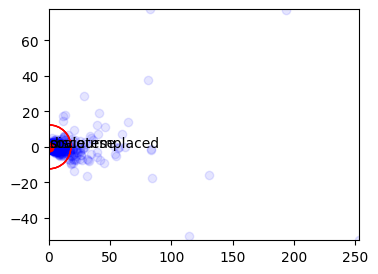

In [ ]:
rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
run_visualization('svd',rand_words, word_to_idx, co_occurrence_matrix)

Annotating words: ['discourse', 'sovietemplaced', 'scale']


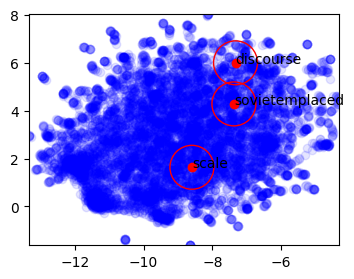

In [ ]:
run_visualization('umap',rand_words, word_to_idx, co_occurrence_matrix)

### Test all oov embedding strategies


Building embedding matrix with OOV strategy: random


100%|██████████| 2873/2873 [00:00<00:00, 12530.44it/s]


Annotating words: ['prostitutionwow', 'consume', 'trojan']


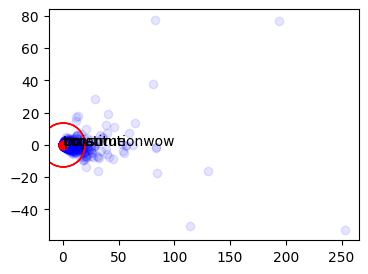

Annotating words: ['prostitutionwow', 'consume', 'trojan']


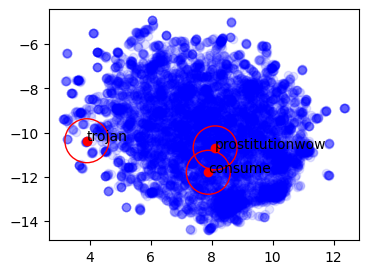


Building embedding matrix with OOV strategy: context


100%|██████████| 2873/2873 [00:00<00:00, 13247.52it/s]


Annotating words: ['sympathy', 'chefayo', 'ref']


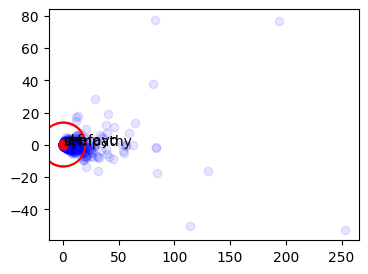

Annotating words: ['sympathy', 'chefayo', 'ref']


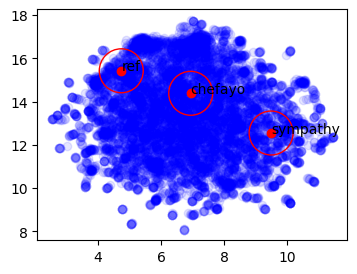


Building embedding matrix with OOV strategy: mean


100%|██████████| 2873/2873 [00:00<00:00, 11480.89it/s]


Annotating words: ['agender', 'best', 'scripture']


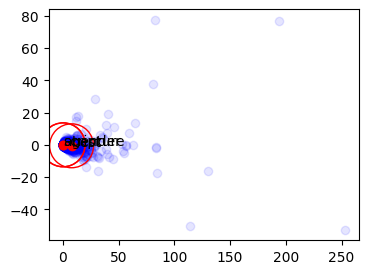

Annotating words: ['agender', 'best', 'scripture']


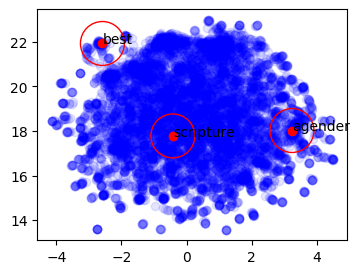


Building embedding matrix with OOV strategy: subwords


100%|██████████| 2873/2873 [00:00<00:00, 10669.26it/s]


Annotating words: ['leftover', 'celebration', 'creatives']


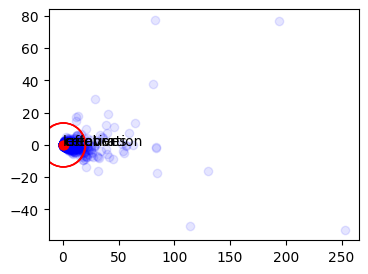

Annotating words: ['leftover', 'celebration', 'creatives']


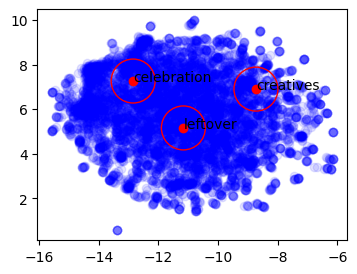


Building embedding matrix with OOV strategy: similarity


100%|██████████| 2873/2873 [00:00<00:00, 10014.20it/s]


Annotating words: ['leftover', 'celebration', 'creatives']


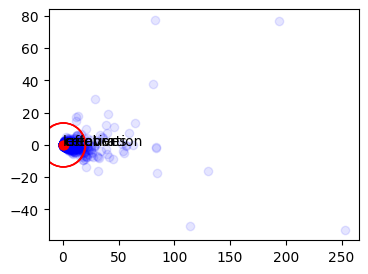

Annotating words: ['leftover', 'celebration', 'creatives']


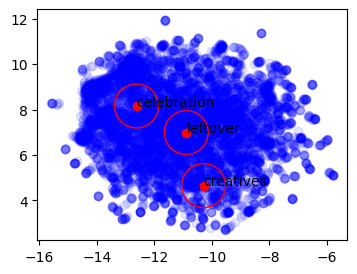

In [ ]:
for strategy in ['random', 'context', 'mean', 'subwords', 'similarity']:
    print(f"\nBuilding embedding matrix with OOV strategy: {strategy}")
    embedding_matrix = build_embedding_matrix(
        embedding_model=embedding_model,
        embedding_dimension=embedding_dimension,
        word_to_idx=word_to_idx,
        vocab_size=vocab_size,
        oov_terms=oov_terms,
        unk_token="<UNK>",
        oov_strategy=strategy,
    )

    co_occurrence_matrix = co_occurrence_count(train_df,
                                            idx_to_word,
                                            word_to_idx,
                                            window_size=4)

    rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
    run_visualization('svd',rand_words, word_to_idx, co_occurrence_matrix)
    run_visualization('umap',rand_words, word_to_idx, co_occurrence_matrix)

## Task 4

In [ ]:
batch_size = 16
hidden_dim = 128

def text_to_indices(text, word_to_idx, unk_token="<UNK>"):
    """Convert text to a list of indices based on the word_to_idx mapping."""
    return [word_to_idx.get(t, word_to_idx[unk_token]) for t in text.split()]

### Tweet Dataset

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, df, word_to_idx, unk_token="<UNK>"):
        self.sequences = [text_to_indices(t, word_to_idx, unk_token) for t in df['tweet'].values]
        self.labels = df['label'].values.astype(int)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_seqs = rnn_utils.pad_sequence([torch.tensor(seq) for seq in sequences],
                                         batch_first=True, padding_value=word_to_idx["<PAD>"])
    labels = torch.tensor(labels)
    return padded_seqs, labels, lengths


train_loader = DataLoader(TweetDataset(train_df, word_to_idx), batch_size=batch_size,
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TweetDataset(val_df, word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(TweetDataset(test_df, word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)

### Bidirectional LSTM model

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.3):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=word_to_idx["<PAD>"])
        self.bilstm = nn.LSTM(input_size=embedding_dim,
                              hidden_size=hidden_dim,
                              num_layers=num_layers,
                              bidirectional=True,
                              batch_first=True,
                              dropout=dropout if num_layers>1 else 0)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(),
                                                      batch_first=True,
                                                      enforce_sorted=False)
            packed_out, (h_n, c_n) = self.bilstm(packed)
        else:
            # without lengths use full sequences
            out, (h_n, c_n) = self.bilstm(embedded)

        # hidden state concatenation
        h_forward = h_n[-2,:,:]
        h_backward = h_n[-1,:,:]
        h = torch.cat((h_forward, h_backward), dim=1)
        out = self.fc(h)
        return out

In [ ]:
baseline_model = BiLSTMClassifier(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, num_classes=4, num_layers=1, dropout=0.3)

In [ ]:
# max_string_length = train_df_stats['string_length'].max()
max_string_length = 230
print(f"Lunghezza massima del tweet in caratteri: {max_string_length}")

summary(baseline_model, input_size=(16, max_string_length), dtypes=[torch.long])

Lunghezza massima del tweet in caratteri: 230


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMClassifier                         [16, 4]                   --
├─Embedding: 1-1                         [16, 230, 50]             472,950
├─LSTM: 1-2                              [16, 230, 256]            184,320
├─Linear: 1-3                            [16, 4]                   1,028
Total params: 658,298
Trainable params: 658,298
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 685.88
Input size (MB): 0.03
Forward/backward pass size (MB): 9.01
Params size (MB): 2.63
Estimated Total Size (MB): 11.67

## Task 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

lr = 1e-4
num_epochs = 10

Using device: cuda


#### Training functions

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    """
    Train the model for one epoch.

    Parameters:
    - model: the neural network model
    - loader: DataLoader for training data
    - optimizer: optimizer for updating model parameters
    - criterion: loss function
    - device: CPU or GPU
    Returns:
    - average loss and accuracy for the epoch
    """
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for batch in loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])
    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc

def eval_epoch(model, loader, criterion, device):
    """
    Evaluate the model for one epoch.
    Parameters:
    - model: the neural network model
    - loader: DataLoader for validation/data
    - criterion: loss function
    - device: CPU or GPU
    Returns:
    - average loss, accuracy, precision, recall, and F1-score for the epoch
    """
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels, lengths = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])
    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=np.nan) if len(all_labels) else 0.0
    rec = recall_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    f1 = f1_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc, prec, rec, f1

def train_loop(model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=True):
    """
    Perform the model training.
    Parameters:
    - model: the neural network model
    - num_epochs: number of training epochs
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - optimizer: optimizer for updating model parameters
    - criterion: loss function
    - device: CPU or GPU
    - verbose: whether to print progress
    Returns:
    - history: dictionary containing training and validation metrics per epoch
    """
    best_val_acc = 0.0
    best_state = None
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_prec': [],
        'val_rec': [],
        'val_f1': [],
    }

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1 = eval_epoch(model, val_loader, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)

        if verbose:
            print(f"Epoch {epoch}/{num_epochs} — train loss: {train_loss:.4f} — val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, val prec: {val_prec:.4f}, val rec: {val_rec:.4f}, val f1: {val_f1:.4f}")

    return history

#### Evaluation function

In [ ]:
def eval_model(model, loader, device):
    """
    Evaluate the model.
    Parameters:
    - model: the neural network model
    - loader: DataLoader for evaluation data
    - device: CPU or GPU
    Returns:
    - accuracy, precision, recall, and F1-score
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels, lengths = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            outputs = model(inputs, lengths)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds) if all_preds else np.array([])
    all_labels = np.concatenate(all_labels) if all_labels else np.array([])
    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=np.nan) if len(all_labels) else 0.0
    rec = recall_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    f1 = f1_score(all_labels, all_preds, average='macro') if len(all_labels) else 0.0
    return acc, prec, rec, f1


### Training and Evaluation over many seeds

In [ ]:
best_model = None
best_history = None
criterion = nn.CrossEntropyLoss()
training_report = {'baseline': [], 'stacked': []}
seeds = np.random.randint(0, 1000, size=3)
best_f1 = 0

for seed in seeds:  # try 3 different random seeds
    print(f"\nRandom seed: {seed}")
    baseline_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=1)
    baseline_model.to(device)
    optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
    baseline_model_history = train_loop(baseline_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
    training_report['baseline'].append(eval_model(baseline_model, test_loader, device))
    print("Baseline training: ", training_report['baseline'][-1])
    if baseline_model_history['val_f1'][-1] > best_f1:
        best_f1 = baseline_model_history['val_f1'][-1]
        best_model = copy.deepcopy(baseline_model)
        best_history = baseline_model_history

    stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
    stacked_model.to(device)
    optimizer = optim.Adam(stacked_model.parameters(), lr=lr)
    stacked_model_history = train_loop(stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
    training_report['stacked'].append(eval_model(stacked_model, val_loader, device))
    print("Stacked training: ", training_report['stacked'][-1])
    if stacked_model_history['val_f1'][-1] > best_f1:
        best_f1 = stacked_model_history['val_f1'][-1]
        best_model = copy.deepcopy(stacked_model)
        best_history = stacked_model_history

    # print("========================================")

print("Best f1 score: ", best_f1)


Random seed: 997
Baseline training:  (0.6678571428571428, 0.5780926204655018, 0.3480110101348162, 0.3572871572871573)
Stacked training:  (0.7266666666666667, 0.5309106098579782, 0.33739648033126296, 0.34011280187750775)

Random seed: 515
Baseline training:  (0.6642857142857143, 0.50962485790072, 0.3492499721099469, 0.3511204165615377)
Stacked training:  (0.7066666666666667, 0.5592314118629909, 0.34169254658385095, 0.35336134453781515)

Random seed: 683
Baseline training:  (0.6785714285714286, 0.5656660692951015, 0.3522009542688944, 0.35973516052044036)
Stacked training:  (0.72, 0.5427350427350427, 0.35346790890269153, 0.36156709044199986)
Best f1 score:  0.36156709044199986


In [ ]:
for idx, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    baseline_scores = [run[idx] for run in training_report['baseline']]
    stacked_scores = [run[idx] for run in training_report['stacked']]
    print(f"{metric} - Baseline: Mean = {np.mean(baseline_scores):.4f}, Std Dev = {np.std(baseline_scores):.4f} | Stacked: Mean = {np.mean(stacked_scores):.4f}, Std Dev = {np.std(stacked_scores):.4f}")

Accuracy - Baseline: Mean = 0.6702, Std Dev = 0.0061 | Stacked: Mean = 0.7178, Std Dev = 0.0083
Precision - Baseline: Mean = 0.5511, Std Dev = 0.0298 | Stacked: Mean = 0.5443, Std Dev = 0.0116
Recall - Baseline: Mean = 0.3498, Std Dev = 0.0018 | Stacked: Mean = 0.3442, Std Dev = 0.0068
F1 - Baseline: Mean = 0.3560, Std Dev = 0.0036 | Stacked: Mean = 0.3517, Std Dev = 0.0088


### Visualization for the best model

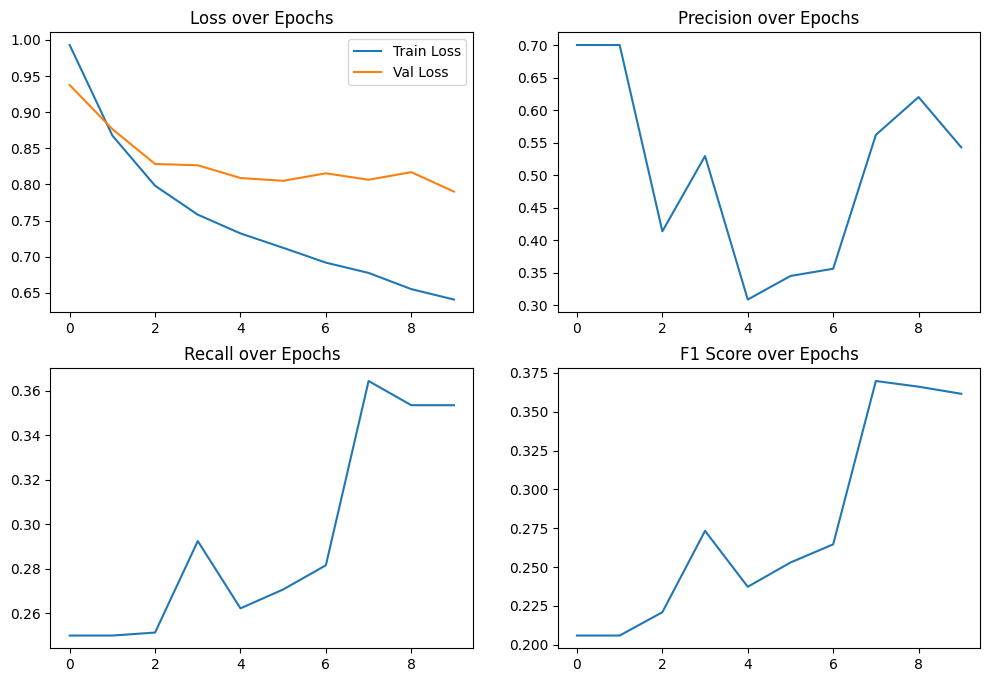

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(best_history['val_prec'], label='Val Precision')
plt.title('Precision over Epochs')

plt.subplot(2, 2, 3)
plt.plot(best_history['val_rec'], label='Val Recall')
plt.title('Recall over Epochs')

plt.subplot(2, 2, 4)
plt.plot(best_history['val_f1'], label='Val F1')
plt.title('F1 Score over Epochs')

plt.show()

In [ ]:
# Print some predictions with the best model
best_model.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs, labels, lengths = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        outputs = best_model(inputs, lengths)
        preds = outputs.argmax(dim=1).cpu().numpy()

        for i in range(inputs.size(0)):
            if labels[i].item() != 0:  # print only non-neutral tweets
                input_indices = inputs[i][:lengths[i]].cpu().numpy()
                input_words = [idx_to_word[idx] for idx in input_indices]
                print("Tweet:", " ".join(input_words))
                print("True label:", labels[i].item())
                print("Predicted label:", preds[i])
                print("")

Tweet: right push opposite direction convert female space <UNK> sex deny woman girl privacy safety male free area male behaviour problem female behaviour change must preserve boundary
True label: 3
Predicted label: 0

Tweet: man move <UNK> <UNK> <UNK> <UNK> train think good position completely reach rush train couple stop woman cant <UNK> <UNK> apparently
True label: 3
Predicted label: 0

Tweet: every second american sexually <UNK> read decide care survey find woman experience street harassment among woman sexually touch
True label: 3
Predicted label: 3

Tweet: sincerely wish u progressive womens right
True label: 2
Predicted label: 0

Tweet: need call day without woman woman amp ally usa <UNK> <UNK> <UNK>
True label: 1
Predicted label: 1

Tweet: day without woman would really economy
True label: 1
Predicted label: 0

Tweet: nearly student encounter sexual misconduct school
True label: 3
Predicted label: 0

Tweet: first scar stalking find <UNK> side realize sweet salty like good treat 

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\nn\modules\rnn.py:1136: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1481.)
  result = _VF.lstm(


### Training for different oov strategies

In [ ]:
for strategy in ['random', 'context', 'mean', 'subwords', 'similarity']:
    print(f"\nOOV strategy: {strategy}")
    embedding_matrix = build_embedding_matrix(
        embedding_model=embedding_model,
        embedding_dimension=embedding_dimension,
        word_to_idx=word_to_idx,
        vocab_size=vocab_size,
        oov_terms=oov_terms,
        unk_token="<UNK>",
        oov_strategy=strategy,
    )

    best_model = None
    best_history = None
    criterion = nn.CrossEntropyLoss()
    training_report = {'stacked': []}
    seeds = np.random.randint(0, 1000, size=3)
    best_f1 = 0

    for seed in seeds:
        stacked_model = BiLSTMClassifier(embedding_matrix, hidden_dim=hidden_dim, num_layers=2)
        stacked_model.to(device)
        optimizer = optim.Adam(stacked_model.parameters(), lr=lr)
        stacked_model_history = train_loop(stacked_model, num_epochs, train_loader, val_loader, optimizer, criterion, device, verbose=False)
        training_report['stacked'].append(eval_model(stacked_model, val_loader, device))
        if stacked_model_history['val_f1'][-1] > best_f1:
            best_f1 = stacked_model_history['val_f1'][-1]
            best_model = copy.deepcopy(stacked_model)
            best_history = stacked_model_history

    print("Best f1 score: ", best_f1)
    for idx, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
        stacked_scores = [run[idx] for run in training_report['stacked']]
        print(f"{metric} - Stacked: Mean = {np.mean(stacked_scores):.4f}, Std Dev = {np.std(stacked_scores):.4f}")


OOV strategy: random


Building embedding matrix: 100%|██████████| 9459/9459 [00:00<00:00, 15824.54it/s]


Best f1 score:  0.3790560471976401
Accuracy - Stacked: Mean = 0.7156, Std Dev = 0.0166
Precision - Stacked: Mean = 0.5212, Std Dev = 0.0105
Recall - Stacked: Mean = 0.3783, Std Dev = 0.0113
F1 - Stacked: Mean = 0.3761, Std Dev = 0.0041

OOV strategy: context


Building embedding matrix: 100%|██████████| 9459/9459 [00:03<00:00, 2448.48it/s] 


Best f1 score:  0.3571831940365936
Accuracy - Stacked: Mean = 0.7044, Std Dev = 0.0083
Precision - Stacked: Mean = 0.4672, Std Dev = 0.0353
Recall - Stacked: Mean = 0.3196, Std Dev = 0.0233
F1 - Stacked: Mean = 0.3173, Std Dev = 0.0284

OOV strategy: mean


Building embedding matrix: 100%|██████████| 9459/9459 [00:00<00:00, 19923.08it/s]


Best f1 score:  0.33916900093370683
Accuracy - Stacked: Mean = 0.7089, Std Dev = 0.0031
Precision - Stacked: Mean = 0.4877, Std Dev = 0.0185
Recall - Stacked: Mean = 0.3235, Std Dev = 0.0133
F1 - Stacked: Mean = 0.3242, Std Dev = 0.0162

OOV strategy: subwords


Building embedding matrix: 100%|██████████| 9459/9459 [00:01<00:00, 7291.59it/s] 


Best f1 score:  0.38847117794486213
Accuracy - Stacked: Mean = 0.7156, Std Dev = 0.0083
Precision - Stacked: Mean = 0.5132, Std Dev = 0.0248
Recall - Stacked: Mean = 0.3434, Std Dev = 0.0289
F1 - Stacked: Mean = 0.3444, Std Dev = 0.0313

OOV strategy: similarity


Building embedding matrix: 100%|██████████| 9459/9459 [01:58<00:00, 79.83it/s]  


Best f1 score:  0.3678420735382761
Accuracy - Stacked: Mean = 0.7178, Std Dev = 0.0083
Precision - Stacked: Mean = 0.5235, Std Dev = 0.0457
Recall - Stacked: Mean = 0.3442, Std Dev = 0.0111
F1 - Stacked: Mean = 0.3499, Std Dev = 0.0169


## Task 6

In [11]:
!pip install datasets
!pip install transformers
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [43]:
from datasets import Dataset

from sklearn.metrics import f1_score, accuracy_score
from evaluate import load

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoConfig
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback

import random

In [13]:
# We don't have to use the already preprocessed dataframes, because RoBERTa has its own preprocessing

train_data = Dataset.from_pandas(train_df_np)
val_data = Dataset.from_pandas(val_df_np)
test_data = Dataset.from_pandas(test_df_np)

In [14]:
# visualize datasets
print(f"Train dataset visualization:\n {train_data}")
print("")
print(f"Test dataset visualization:\n {test_data}")


Train dataset visualization:
 Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__'],
    num_rows: 2873
})

Test dataset visualization:
 Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__'],
    num_rows: 280
})


In [15]:
# define model_card and model tokenizer
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
print(MODEL)

cardiffnlp/twitter-roberta-base-hate


In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [17]:
# From Roberta-base-hate documentation -> maybe we can remove it

def preprocess_batch(batch):
    processed = []
    for text in batch["tweet"]:
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        processed.append(" ".join(new_text))
    batch["tweet"] = processed
    return batch

train_data = train_data.map(preprocess_batch, batched=True)
val_data = val_data.map(preprocess_batch, batched=True)
test_data = test_data.map(preprocess_batch, batched=True)


Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

### Dataset Inspection

In [18]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)

train_data = train_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)

Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [19]:
print(train_data)
print(test_data)

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2873
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 280
})


In [20]:
idx = np.random.randint(0, len(train_data))

print("First 200 input IDs for a random example:")
print(train_data['input_ids'][idx][:200])

print("\nFirst 200 attention mask values:")
print(train_data['attention_mask'][idx][:200])

print("\nOriginal tweet text:")
print(train_data['tweet'][idx][:200])

First 200 input IDs for a random example:
[0, 10993, 693, 54, 21, 4241, 19, 12821, 9421, 21, 11145, 9744, 4, 404, 5, 55, 98, 11145, 390, 33, 7, 1032, 7, 28, 2222, 8, 3871, 1567, 604, 4, 2691, 32, 45, 3007, 5868, 4634, 51, 33, 7, 33, 10, 235, 7, 2845, 59, 49, 659, 8, 809, 328, 849, 7199, 3762, 9690, 2054, 2]

First 200 attention mask values:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Original tweet text:
First woman who was awarded with Nobel Prize was Polish scientist. All the more so Polish women have to fight to be independent and equal towards men. Women are not worse humans thus they have to have


Roberta special tokens

We have seen 0 and 2 ids as the first and last tokens of the tweet

In [21]:
for name, token in tokenizer.special_tokens_map.items():
    print(f"{name}: {token} -> id {tokenizer.convert_tokens_to_ids(token)}")

bos_token: <s> -> id 0
eos_token: </s> -> id 2
unk_token: <unk> -> id 3
sep_token: </s> -> id 2
pad_token: <pad> -> id 1
cls_token: <s> -> id 0
mask_token: <mask> -> id 50264


RoBERTa’s tokenizer works at the byte level and uses a special character, “Ġ”, to indicate that a token begins with a space. This is why you see tokens like “ĠGreat” or “Ġdata”: the “Ġ” simply marks that these words originally had a space before them.

In [22]:
example_test = train_data['tweet'][idx]
encoded_example = tokenizer.encode_plus(example_test, add_special_tokens=False)
print(encoded_example.tokens())

['First', 'Ġwoman', 'Ġwho', 'Ġwas', 'Ġawarded', 'Ġwith', 'ĠNobel', 'ĠPrize', 'Ġwas', 'ĠPolish', 'Ġscientist', '.', 'ĠAll', 'Ġthe', 'Ġmore', 'Ġso', 'ĠPolish', 'Ġwomen', 'Ġhave', 'Ġto', 'Ġfight', 'Ġto', 'Ġbe', 'Ġindependent', 'Ġand', 'Ġequal', 'Ġtowards', 'Ġmen', '.', 'ĠWomen', 'Ġare', 'Ġnot', 'Ġworse', 'Ġhumans', 'Ġthus', 'Ġthey', 'Ġhave', 'Ġto', 'Ġhave', 'Ġa', 'Ġright', 'Ġto', 'Ġdecide', 'Ġabout', 'Ġtheir', 'Ġrights', 'Ġand', 'Ġbody', '!', 'Ġ#', 'Not', 'One', 'More', 'Ġhttp']


In [23]:
def show_tokenization_examples(dataset, tokenizer, text_column="tweet", n=2, max_len=200):
    """
    Display original text and tokenizer-decoded text side by side for N random examples.

    Parameters:
    - dataset: Hugging Face Dataset (already tokenized)
    - tokenizer: Hugging Face tokenizer
    - text_column: name of the column containing the original text
    - n: number of random examples to display
    - max_len: maximum number of characters to print
    """
    total = len(dataset)
    indices = random.sample(range(total), n)

    for idx in indices:
        original_text = dataset[text_column][idx]
        input_ids = dataset['input_ids'][idx]
        decoded_text = tokenizer.decode(input_ids)

        print(f"=== Example {idx} ===")
        print("Original text:")
        print(original_text[:max_len])
        print("\nDecoded text from tokenizer:")
        print(decoded_text[:max_len])
        print("-" * 50)

In [24]:
show_tokenization_examples(
    dataset=train_data,
    tokenizer=AutoTokenizer.from_pretrained(MODEL)
)

=== Example 2039 ===
Original text:
I will never understand how niggas are worried about someone's sexual identity and lifestyle unless they are dating. But even then why are you worried about what others that you don't know personally 

Decoded text from tokenizer:
<s>I will never understand how niggas are worried about someone's sexual identity and lifestyle unless they are dating. But even then why are you worried about what others that you don't know personal
--------------------------------------------------
=== Example 201 ===
Original text:
@user @user @user He used hi influence to mentally and physically force a young woman into sleeping with him… she had to give her emotions to ease the pain …it’s still abuse and rape

Decoded text from tokenizer:
<s>@user @user @user He used hi influence to mentally and physically force a young woman into sleeping with him… she had to give her emotions to ease the pain …it’s still abuse and rape</s>
-------------------------------------------

### Model creation and training

In [25]:
# format input data to be fed as mini-batches: pad each tweet based on the longest tweet in the mini-batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Since RoBERTa was originally trained for 2 classes, but we want to predict 4 classes in our task, we need to set `ignore_mismatched_sizes=True` when loading the model. This way, the pre-trained weights are kept for all compatible layers, while the classification head is randomly initialized to match the new number of classes.


In [26]:
num_labels = len(np.unique(train_df_np['label']))
id2label = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
label2id = {v:k for k,v in id2label.items()}


In [27]:
# used only to show roberta architecture,
# but we will call these again each with different seeds for reproducibility

config = AutoConfig.from_pretrained(
    MODEL,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# as we can see, now the out_features=4 for the last layer
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Metric Definition

In [29]:
def compute_metrics_SK(output_info):
  predictions, labels = output_info
  predictions = np.argmax(predictions, axis=-1)

  f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
  acc = accuracy_score(y_pred=predictions, y_true=labels)
  return {'f1': f1, 'acc': acc}

In [35]:
acc_metric = load('accuracy')
f1_metric = load('f1')

In [36]:
def compute_metrics_HF(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_metric.compute(predictions=predictions,
                           references=labels,
                           average="macro")

    acc = acc_metric.compute(predictions=predictions,
                             references=labels)

    return {"f1": f1["f1"], "accuracy": acc["accuracy"]}

In [45]:
# use same hyperparam as BiRNN

batch_size = 16
lr = 1e-4
num_epochs = 10

In [46]:
training_args = TrainingArguments(
    output_dir="val_dir/trainer_1",             # where to save model
    learning_rate=lr,
    per_device_train_batch_size=batch_size,     # defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1 # RoBERTa benefits from a small warmup
)

In [49]:
seeds = [42, 1337, 2025]
val_results, test_results = [], []
best_val_f1 = -1
best_model_state = None
best_seed = None

for seed in seeds:
    print(f"\n============================")
    print(f" Running with seed: {seed}")
    print(f"============================\n")

    fix_seed(seed)

    run_args = copy.deepcopy(training_args)
    run_args.output_dir = f"./results/lr_1e4/seed_{seed}"

    config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL, config=config, ignore_mismatched_sizes=True
    )

    trainer = Trainer(
        model=model,
        args=run_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_HF,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Evaluate on validation set
    val_metrics = trainer.evaluate(val_data)
    val_log_entry = {
        "seed": seed,
        "val_f1": val_metrics["eval_f1"],
        "val_loss": val_metrics["eval_loss"]
    }
    val_results.append(val_log_entry)

    print(f"Validation F1 for seed {seed}: {val_log_entry['val_f1']:.4f}")

    # Model selection based on val_f1
    if val_log_entry["val_f1"] > best_val_f1:
        print(f"New Best Model found (Seed {seed}) based on Val F1")
        best_val_f1 = val_log_entry["val_f1"]
        # Move state dict to CPU before copying to save VRAM
        best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
        best_seed = seed

    # ------------------------
    # 3. Evaluate on TEST Set
    # ------------------------
    test_metrics = trainer.evaluate(test_data)
    test_log_entry = {
        "seed": seed,
        "test_f1": test_metrics["eval_f1"],
        "test_loss": test_metrics["eval_loss"]
    }
    test_results.append(test_log_entry)

    print(f"Test F1 for seed {seed}: {test_log_entry['test_f1']:.4f}")


# ===================================
# FINAL RESULTS AND REPORTING
# ===================================
df_val = pd.DataFrame(val_results)
df_test = pd.DataFrame(test_results)

# Validation + Test results
df = pd.merge(df_val, df_test, on="seed")

print("\n===== Results per Seed (Val & Test) =====")
print(df)

mean_f1 = df["test_f1"].mean()
std_f1 = df["test_f1"].std()

print("\n===== Aggregated Results =====")
print(f"Mean F1 (on Test Set): {mean_f1:.4f}")
print(f"Std Dev F1 (on Test Set): {std_f1:.4f}")

print("\nBest seed (selected using Validation F1):", best_seed)
print("Best F1 Validation Score:", best_val_f1)
print(f"Test F1 associated with the best seed: {df[df['seed'] == best_seed]['test_f1'].iloc[0]:.4f}")


df.to_csv("roberta_seed_results.csv", index=False)
torch.save(best_model_state, "best_roberta_model_lr1e4.pt")


 Running with seed: 42



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.821100,0.608879,0.390698,0.786667
2,0.659900,0.648239,0.468885,0.800000
3,0.524700,0.672175,0.460823,0.766667
4,0.388000,0.741379,0.485258,0.793333
5,0.290100,1.024113,0.490059,0.766667
6,0.212100,0.868554,0.533727,0.786667
7,0.108900,1.052358,0.609093,0.800000
8,0.058800,1.418608,0.478937,0.760000
9,0.015900,1.560116,0.505974,0.773333
10,0.006500,1.507869,0.535085,0.786667


Validation F1 for seed 42: 0.6091
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.4848

 Running with seed: 1337



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.776700,0.654198,0.420027,0.760000
2,0.728000,0.631533,0.382777,0.773333
3,0.614900,0.591237,0.542526,0.800000
4,0.483700,0.655797,0.487802,0.786667
5,0.377500,0.705741,0.516499,0.800000
6,0.284700,0.713814,0.585541,0.813333
7,0.200500,0.721573,0.540764,0.800000
8,0.134300,1.000573,0.607147,0.806667
9,0.074800,1.165496,0.620032,0.800000
10,0.028100,1.202540,0.613882,0.800000


Validation F1 for seed 1337: 0.6200
New Best Model found (Seed 1337) based on Val F1
Test F1 for seed 1337: 0.4658

 Running with seed: 2025



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.793200,0.631485,0.465202,0.780000
2,0.668800,0.635409,0.439484,0.760000
3,0.521200,0.562376,0.522228,0.806667
4,0.367000,0.659272,0.567273,0.800000
5,0.269300,0.997330,0.516204,0.786667
6,0.206300,0.996463,0.506709,0.786667
7,0.154000,1.055071,0.547201,0.786667


Validation F1 for seed 2025: 0.5673
Test F1 for seed 2025: 0.4794

===== Results per Seed (Val & Test) =====
   seed    val_f1  val_loss   test_f1  test_loss
0    42  0.609093  1.052358  0.484750   1.667073
1  1337  0.620032  1.165496  0.465778   1.649366
2  2025  0.567273  0.659272  0.479383   0.953909

===== Aggregated Results =====
Mean F1 (on Test Set): 0.4766
Std Dev F1 (on Test Set): 0.0098

Best seed (selected using Validation F1): 1337
Best F1 Validation Score: 0.6200319844249756
Test F1 associated with the best seed: 0.4658


Let's try with the standard lr for RoBERTa, i.e. `lr = 2e-5`

In [50]:
model_2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# try with lr=2e-5

training_args_2 = TrainingArguments(
    output_dir="val_dir/trainer_2",             # where to save model
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,     # defines distributed training
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",             # when to report evaluation metrics/losses
    save_strategy="epoch",             # when to save checkpoint
    logging_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1 # RoBERTa benefits from a small warmup
)

In [59]:
seeds = [42, 1337, 2025]
val_results, test_results = [], []
best_val_f1 = -1
best_model_state = None
best_seed = None

for seed in seeds:
    print(f"\n============================")
    print(f" Running with seed: {seed}")
    print(f"============================\n")

    fix_seed(seed)

    run_args = copy.deepcopy(training_args_2)
    run_args.output_dir = f"./results/lr_2e5/seed_{seed}"

    config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL, config=config, ignore_mismatched_sizes=True
    )

    trainer_2 = Trainer(
        model=model,
        args=run_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_HF,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer_2.train()

    # Evaluate on validation set
    val_metrics = trainer_2.evaluate(val_data)
    val_log_entry = {
        "seed": seed,
        "val_f1": val_metrics["eval_f1"],
        "val_loss": val_metrics["eval_loss"]
    }
    val_results.append(val_log_entry)

    print(f"Validation F1 for seed {seed}: {val_log_entry['val_f1']:.4f}")

    # Model selection based on val_f1
    if val_log_entry["val_f1"] > best_val_f1:
        print(f"New Best Model found (Seed {seed}) based on Val F1")
        best_val_f1 = val_log_entry["val_f1"]
        # Move state dict to CPU before copying to save VRAM
        best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
        best_seed = seed

    # ------------------------
    # 3. Evaluate on TEST Set
    # ------------------------
    test_metrics = trainer_2.evaluate(test_data)
    test_log_entry = {
        "seed": seed,
        "test_f1": test_metrics["eval_f1"],
        "test_loss": test_metrics["eval_loss"]
    }
    test_results.append(test_log_entry)

    print(f"Test F1 for seed {seed}: {test_log_entry['test_f1']:.4f}")


# ===================================
# FINAL RESULTS AND REPORTING
# ===================================
df_val = pd.DataFrame(val_results)
df_test = pd.DataFrame(test_results)

# Merge results for a comprehensive report
df = pd.merge(df_val, df_test, on="seed")

print("\n===== Results per Seed (Val & Test) =====")
print(df)

mean_f1 = df["test_f1"].mean()
std_f1 = df["test_f1"].std()

print("\n===== Aggregated Results =====")
print(f"Mean F1 (on Test Set): {mean_f1:.4f}")
print(f"Std Dev F1 (on Test Set): {std_f1:.4f}")

print("\nBest seed (selected using Val F1):", best_seed)
print("Best F1 Validation Score:", best_val_f1)
print(f"Test F1 associated with the best seed: {df[df['seed'] == best_seed]['test_f1'].iloc[0]:.4f}")


df.to_csv("roberta_seed_results.csv", index=False)
torch.save(best_model_state, "best_roberta_model_lr2e5.pt")


 Running with seed: 42



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.893800,0.605745,0.430792,0.800000
2,0.577300,0.586199,0.514488,0.806667
3,0.423300,0.598939,0.606351,0.806667
4,0.292800,0.783473,0.549242,0.780000
5,0.194000,0.863499,0.612159,0.793333
6,0.131100,0.997422,0.645738,0.806667
7,0.078800,1.142907,0.523888,0.766667
8,0.051100,1.256810,0.505061,0.786667
9,0.030700,1.346066,0.507905,0.766667


Validation F1 for seed 42: 0.6457
New Best Model found (Seed 42) based on Val F1
Test F1 for seed 42: 0.5355

 Running with seed: 1337



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.800900,0.609208,0.381532,0.786667
2,0.579800,0.594818,0.507606,0.806667
3,0.429200,0.615551,0.583013,0.806667
4,0.290700,0.754403,0.534811,0.786667
5,0.195400,0.968671,0.468133,0.773333
6,0.137000,1.002215,0.514212,0.766667


Validation F1 for seed 1337: 0.5830
Test F1 for seed 1337: 0.4780

 Running with seed: 2025



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.850300,0.597631,0.431586,0.800000
2,0.575900,0.563150,0.511166,0.806667
3,0.412100,0.609315,0.557874,0.820000
4,0.281200,0.772628,0.486899,0.786667
5,0.183200,0.882867,0.556578,0.786667
6,0.139000,1.002807,0.555941,0.786667


Validation F1 for seed 2025: 0.5579
Test F1 for seed 2025: 0.4643

===== Results per Seed (Val & Test) =====
   seed    val_f1  val_loss   test_f1  test_loss
0    42  0.645738  0.997422  0.535481   1.303459
1  1337  0.583013  0.615551  0.477960   0.766602
2  2025  0.557874  0.609315  0.464252   0.788852

===== Aggregated Results =====
Mean F1 (on Test Set): 0.4926
Std Dev F1 (on Test Set): 0.0378

Best seed (selected using Val F1): 42
Best F1 Validation Score: 0.6457377192489494
Test F1 associated with the best seed: 0.5355


### Show Predictions

In [60]:
fix_seed(best_seed)

In [61]:
config = AutoConfig.from_pretrained(
        MODEL, num_labels=4, id2label=id2label, label2id=label2id
    )

best_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, config=config, ignore_mismatched_sizes=True
)

best_model.load_state_dict(torch.load('best_roberta_model_lr2e5.pt'))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [63]:
prediction_args = TrainingArguments(
    output_dir="./prediction_output",
    per_device_eval_batch_size=batch_size,
    eval_strategy="no",
    save_strategy="no",
    report_to='none',
)

In [64]:
best_trainer_2 = Trainer(
    model=best_model,
    args=prediction_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics_HF
)

In [65]:
# 1. Get predictions on the test set
predictions_output = best_trainer_2.predict(test_data)
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

# 2. Decode the original tweets
decoded_texts = tokenizer.batch_decode(test_data['input_ids'], skip_special_tokens=True)

print("=== Prediction vs Ground Truth labels (Non-Neutral Only) ===\n")

id2label = {0: '-', 1: 'DIRECT', 2: 'JUDGEMENTAL', 3: 'REPORTED'}

count = 0
target_count = 10
max_attempts = 1000 # to prevent infinite loops

while count < target_count and max_attempts > 0:
    idx = np.random.randint(0, len(preds))
    max_attempts -= 1

    # Since the dataset is imbalanced towards class 0, we only show
    # how the model behaves for the other 3 classes
    if labels[idx] != 0:
        print(f"Tweet: {decoded_texts[idx]}")
        print(f"True label:      {id2label[labels[idx]]} ({labels[idx]})")
        print(f"Predicted label: {id2label[preds[idx]]} ({preds[idx]})")

        result = "CORRECT" if labels[idx] == preds[idx] else "WRONG"
        print(f"Result: {result}")
        print("-" * 50)

        # increment the counter if we actually printed an example
        count += 1

if count == 0:
    print("No non-neutral tweets found in the random search.")

=== Prediction vs Ground Truth labels (Non-Neutral Only) ===

Tweet: i hate liars😂. specifically those who lie bc they think they get cool points from that shit, like no you look like a bitch.
True label:      DIRECT (1)
Predicted label: DIRECT (1)
Result: CORRECT
--------------------------------------------------
Tweet: Hot girls can’t get nowhere without a GPS
True label:      DIRECT (1)
Predicted label: DIRECT (1)
Result: CORRECT
--------------------------------------------------
Tweet: @user I don’t care what gender, race, religion,sexual orientation a person is as long as they are qualified for that position. That being said, is she qualified based on experience/education or was she chosen solely because she is black and gay to please progressives/woke. Just saying.
True label:      DIRECT (1)
Predicted label: - (0)
Result: WRONG
--------------------------------------------------
Tweet: why is “women shouldn’t have sex” a reasonable answer to save kids lives, but “citizens shouldn

### Confusion Matrix

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

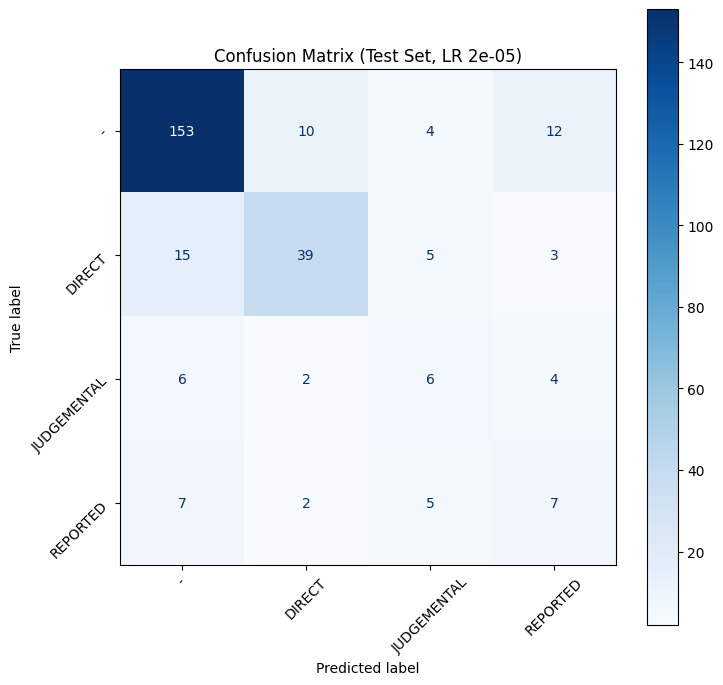

In [78]:
cm = confusion_matrix(y_true=labels, y_pred=preds)

class_labels = list(id2label.values())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

ax.set_title(f'Confusion Matrix (Test Set, LR {run_args.learning_rate})')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

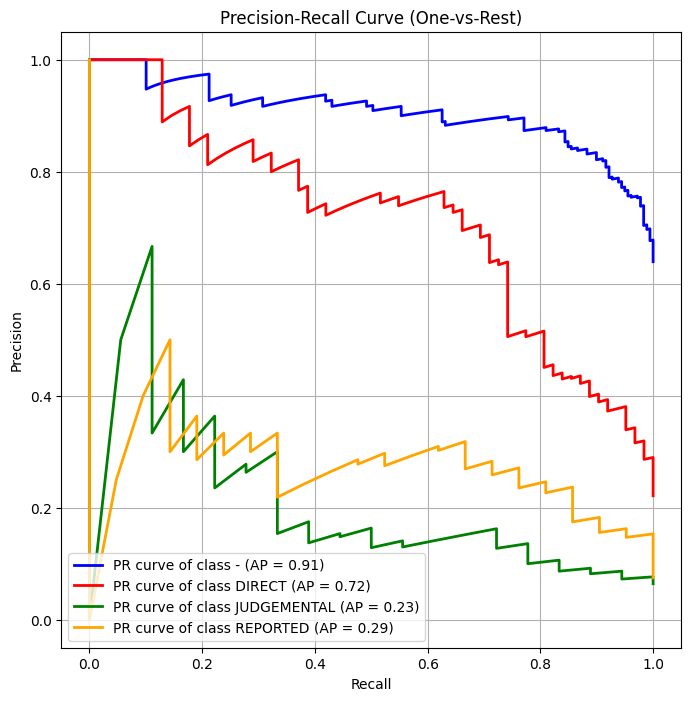

In [80]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle

# Ottieni le probabilità (logits) dal modello
predictions_output = best_trainer_2.predict(test_data)
logits = predictions_output.predictions

# Applica la funzione softmax per ottenere le probabilità
probabilities = torch.softmax(torch.tensor(logits), dim=1).numpy()
labels = predictions_output.label_ids

# Disegna la PR Curve (One-vs-Rest)
plt.figure(figsize=(8, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
class_labels = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED'] # Nomi delle classi

for i, color in zip(range(4), colors):
    # Per ogni classe, binarizza le etichette (vero se è la classe i, falso altrimenti)
    binary_labels = (labels == i)

    # Calcola Precision, Recall e Soglia per la classe i
    precision, recall, _ = precision_recall_curve(binary_labels, probabilities[:, i])

    # Calcola l'Area Sotto la Curva (Average Precision)
    ap = average_precision_score(binary_labels, probabilities[:, i])

    # Disegna la curva
    plt.plot(recall, precision, color=color, lw=2,
             label=f'PR curve of class {class_labels[i]} (AP = {ap:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

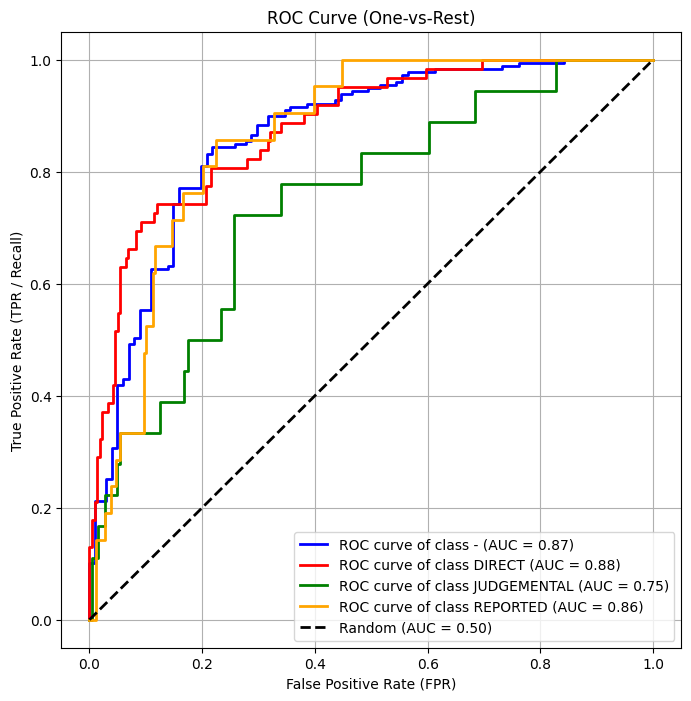

In [84]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

plt.figure(figsize=(8, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
class_labels = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']

for i, color in zip(range(4), colors):
    binary_labels = (labels == i)

    # Compute True Positive Rate (TPR) and False Positive Rate (FPR)
    fpr, tpr, _ = roc_curve(binary_labels, probabilities[:, i])

    # Compute Area Under Curve
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc:.2f})')

# Random classifier plot (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR / Recall)")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Task 7